In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def rgb2gray(_img):
    img = _img.copy().astype(np.float)
    r = img[..., 2].copy()
    g = img[..., 1].copy()
    b = img[..., 0].copy()
    img = 0.2126 * r + 0.7152 * g + 0.0722 * b
    img = img.astype(np.uint8)
    return img

In [3]:
def rgb2hsv(_img):
    img = _img.copy() / 255
    hsv = np.zeros_like(img)
    
    _max = np.max(img, axis=2)
    _min = np.min(img, axis=2)
    min_idx = np.argmin(img, axis=2)
    
    #H
    hsv[..., 0][np.where(_max == _min)] = 0
    a = np.where(min_idx == 2)
    hsv[..., 0][a] = (60 * (img[..., 1][a] - img[..., 0][a])) / (_max[a] - _min[a]) + 60
    a = np.where(min_idx == 0)
    hsv[..., 0][a] = (60 * (img[..., 2][a] - img[..., 1][a])) / (_max[a] - _min[a]) + 180
    a = np.where(min_idx == 1)
    hsv[..., 0][a] = (60 * (img[..., 0][a] - img[..., 2][a])) / (_max[a] - _min[a]) + 300
    
    #S
    hsv[..., 1] = _max - _min
    
    #V
    hsv[..., 2] = _max
    
    return hsv

In [4]:
def otsu_binarization(img):
    img = rgb2gray(img)
    out = img.copy()
    max_sigma = 0
    max_t = 0
    H, W = img.shape
    for _t in range(1, 256):
        v0 = out[np.where(out < _t)]
        m0 = np.mean(v0) if len(v0) > 0 else 0.
        w0 = len(v0) / (H * W)
        v1 = out[np.where(out >= _t)]
        m1 = np.mean(v1) if len(v1) > 0 else 0.
        w1 = len(v1) / (H * W)
        sigma = w0 * w1 * ((m0 - m1) ** 2)
        if sigma > max_sigma:
            max_sigma = sigma
            max_t = _t

    print("threshold >>", max_t)
    th = max_t
    out[out < th] = 0
    out[out >= th] = 255

    return out


def dilate(img):
    out = img.copy()
    k = np.array(((0,1,0), (1,0,1), (0,1,0)), dtype=np.int)
    
    h, w = img.shape
    for i in range(1, h-1):
        for j in range(1, w-1):
            if img[i, j] == 0 and np.sum(img[i-1:i+2, j-1:j+2] * k) >= 255:
                out[i, j] = 255
                
    return out


def erosion(img):
    out = img.copy()
    k = np.array(((0,1,0), (1,0,1), (0,1,0)), dtype=np.int)
    
    h, w = img.shape
    for i in range(1, h-1):
        for j in range(1, w-1):
            if img[i, j] == 255 and np.sum(img[i-1:i+2, j-1:j+2] * k) < 255*4:
                out[i, j] = 0
                
    return out


def opening(img, n=1):
    e = erosion(img)
    if n > 1:
        for i in range(n-1):
            e = erosion(e)
    d = dilate(e)
    if n > 1:
        for i in range(n-1):
            d = erosion(d)
    return d


def closing(img, n=1):
    d = dilate(img)
    if n > 1:
        for i in range(n-1):
            d = dilate(d)
    e = erosion(d)
    if n > 1:
        for i in range(n-1):
            e = erosion(e)
    return e

In [5]:
def bl_interpolate(img, ax=1., ay=1.):
	if len(img.shape) > 2:
		H, W, C = img.shape
	else:
		H, W = img.shape
		C = 1

	aH = int(ay * H)
	aW = int(ax * W)

	# get position of resized image
	y = np.arange(aH).repeat(aW).reshape(aW, -1)
	x = np.tile(np.arange(aW), (aH, 1))

	# get position of original position
	y = (y / ay)
	x = (x / ax)

	ix = np.floor(x).astype(np.int)
	iy = np.floor(y).astype(np.int)

	ix = np.minimum(ix, W-2)
	iy = np.minimum(iy, H-2)

	# get distance 
	dx = x - ix
	dy = y - iy

	if C > 1:
		dx = np.repeat(np.expand_dims(dx, axis=-1), C, axis=-1)
		dy = np.repeat(np.expand_dims(dy, axis=-1), C, axis=-1)

	# interpolation
	out = (1-dx) * (1-dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix+1] + (1 - dx) * dy * img[iy+1, ix] + dx * dy * img[iy+1, ix+1]

	out = np.clip(out, 0, 255)
	out = out.astype(np.uint8)

	return out

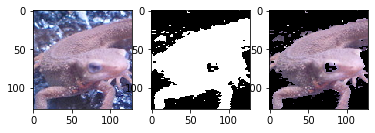

In [31]:
#71
def masking(_img):
    _img = _img.astype(np.float32)
    img = rgb2hsv(_img)
    tmp = img[..., 0]
    bi = np.zeros_like(_img)
    bi[np.where((tmp < 180) | (260 < tmp))] = [1, 1, 1]
    out = _img * bi
    out = out.astype(np.uint8)
    return bi, out


img = cv2.imread('imori.jpg')
img = img[..., ::-1]

mask, out = masking(img)

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.subplot(1, 3, 3)
plt.imshow(out)
plt.show()

threshold >> 1


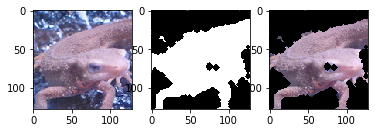

In [42]:
#72
def masking(_img):
    _img = _img.astype(np.float32)
    img = rgb2hsv(_img)
    tmp = img[..., 0]
    bi = np.zeros_like(_img)
    bi[np.where((tmp < 180) | (260 < tmp))] = [1, 1, 1]
    bi = otsu_binarization(bi)
    bi = closing(bi, n=2)
    bi = opening(bi, n=2)
    mask = np.zeros_like(_img)
    mask[bi == 255] = [1, 1, 1]
    out = _img * mask
    out = out.astype(np.uint8)
    return mask, out


img = cv2.imread('imori.jpg')
img = img[..., ::-1]

mask, out = masking(img)

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.subplot(1, 3, 3)
plt.imshow(out)
plt.show()

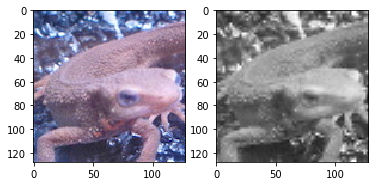

In [68]:
#73
img = cv2.imread('imori.jpg')
img = img[..., ::-1]
gray = rgb2gray(img)

out = bl_interpolate(gray.astype(np.float32), 0.5, 0.5)
out = bl_interpolate(out, 2., 2.)

out = out.astype(np.uint8)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(out, cmap='gray')
plt.show()

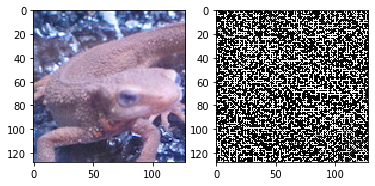

In [71]:
#74
img = cv2.imread('imori.jpg')
img = img[..., ::-1]
gray = rgb2gray(img)

out = bl_interpolate(gray.astype(np.float32), 0.5, 0.5)
out = bl_interpolate(out, 2., 2.)

dif = np.abs(out - gray)
m = np.max(dif)
dif = dif / m * 255
dif = dif.astype(np.uint8)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(dif, cmap='gray')
plt.show()

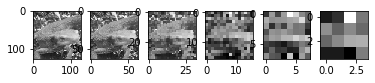

In [79]:
#75
img = cv2.imread('imori.jpg')
img = img[..., ::-1]
gray = rgb2gray(img)

for i in range(6):
    a = 1 / 2**i
    out = bl_interpolate(gray, a, a)
    out = out.astype(np.uint8)
    plt.subplot(1, 6, i+1)
    plt.imshow(out, cmap='gray')
plt.show()

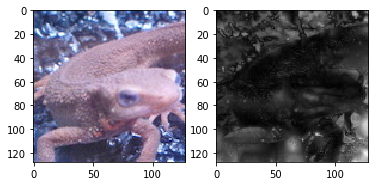

In [10]:
#76
img = cv2.imread('imori.jpg')
img = img[..., ::-1]
gray = rgb2gray(img)

img128 = bl_interpolate(bl_interpolate(gray, 1, 1), 1, 1).astype(np.float32)
img64 = bl_interpolate(bl_interpolate(gray, 1/2, 1/2), 2, 2).astype(np.float32)
img32 = bl_interpolate(bl_interpolate(gray, 1/4, 1/4), 4, 4).astype(np.float32)
img16 = bl_interpolate(bl_interpolate(gray, 1/8, 1/8), 8, 8).astype(np.float32)
img8 = bl_interpolate(bl_interpolate(gray, 1/16, 1/16), 16, 16).astype(np.float32)
img4 = bl_interpolate(bl_interpolate(gray, 1/32, 1/32), 32, 32).astype(np.float32)

out = np.abs(img128 - img64) + np.abs(img128 - img16) + np.abs(img128 - img4) + np.abs(img64 - img8) + np.abs(img32 - img16) + np.abs(img16 - img4)
out = out / np.max(out) * 255

out = out.astype(np.uint8)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(out, cmap='gray')
plt.show()

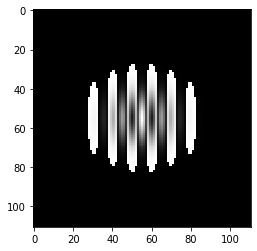

In [21]:
#77
def gabor(_img, size=111, s=10, g=1.2, l=10, p=0, A=0):
    G = np.zeros((size, size), dtype=np.float32)
    d = size // 2
    theta = A * np.pi / 180.
    for y in range(size):
        for x in range(size):
            x_ = np.cos(theta) * (x - d) + np.sin(theta) * (y - d)
            y_ = -np.sin(theta) * (x - d) + np.cos(theta) * (y - d)
            G[y, x] = np.exp(-(x_**2 + g**2 * y_**2) / (2 * s**2)) * np.cos(2 * np.pi * x_ / l + p)
    
    G = G / np.sum(G)
    G = G / np.max(G) * 255
    G = G.astype(np.uint8)
    return G


img = cv2.imread('imori.jpg')
img = img[..., ::-1]

out = gabor(img)

plt.imshow(out, cmap='gray')
plt.show()

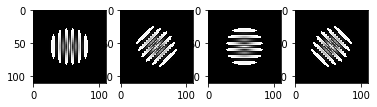

In [24]:
#78
img = cv2.imread('imori.jpg')
img = img[..., ::-1]

for i in range(4):
    out = gabor(img, A=45*i)
    plt.subplot(1, 4, i+1)
    plt.imshow(out, cmap='gray')
plt.show()

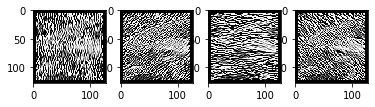

In [30]:
#79
def gabor(_img, size=111, s=10, g=1.2, l=10, p=0, A=0):
    gray = rgb2gray(_img).astype(np.float32)
    h, w = gray.shape
    out = np.zeros((h, w), dtype=np.float32)
    
    G = np.zeros((size, size), dtype=np.float32)
    d = size // 2
    theta = A * np.pi / 180.
    for y in range(size):
        for x in range(size):
            x_ = np.cos(theta) * (x - d) + np.sin(theta) * (y - d)
            y_ = -np.sin(theta) * (x - d) + np.cos(theta) * (y - d)
            G[y, x] = np.exp(-(x_**2 + g**2 * y_**2) / (2 * s**2)) * np.cos(2 * np.pi * x_ / l + p)
    G = G / np.sum(G)
    
    for i in range(d, h-d):
        for j in range(d, w-d):
            out[i, j] = np.sum(gray[i-d:i+d+1, j-d:j+d+1] * G)
    
    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)
    return out


img = cv2.imread('imori.jpg')
img = img[..., ::-1]

for i in range(4):
    out = gabor(img, size=11, s=1.5, g=1.2, l=3, p=0, A=45*i)
    plt.subplot(1, 4, i+1)
    plt.imshow(out, cmap='gray')
plt.show()

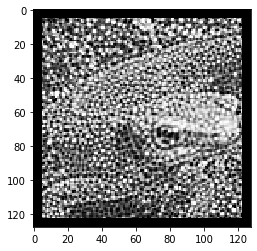

In [42]:
#80
img = cv2.imread('imori.jpg')
img = img[..., ::-1]

out = np.zeros_like(rgb2gray(img), dtype=np.float32)
for i in range(4):
    g = gabor(img, size=11, s=1.5, g=1.2, l=3, p=0, A=45*i).astype(np.float32)
    out = out + g
    
out = out / np.max(out) * 255
out = out.astype(np.uint8)
plt.imshow(out, cmap='gray')
plt.show()